In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

# Define the path to the zipped dataset file in Google Drive
zip_file_path = '/content/drive/MyDrive/Cartoon Images Dataset.zip'

# Define the local directory where the dataset will be unzipped
extraction_dir = 'cartoon_dataset'

# Create the target directory if it doesn't already exist
os.makedirs(extraction_dir, exist_ok=True)

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f"Dataset successfully unzipped to '{extraction_dir}'")

Dataset successfully unzipped to 'cartoon_dataset'


In [3]:
import pandas as pd
import os

image_filepaths = []
labels = []

for root, dirs, files in os.walk(extraction_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(root, file)
            label = os.path.basename(root)
            image_filepaths.append(filepath)
            labels.append(label)

df = pd.DataFrame({
    'filepath': image_filepaths,
    'label': labels
})

print("DataFrame created successfully.")
print("First 5 rows of the DataFrame:")
print(df.head())

print("\nDistribution of labels:")
print(df['label'].value_counts())

DataFrame created successfully.
First 5 rows of the DataFrame:
                                            filepath         label
0  cartoon_dataset/Cartoon Images Dataset/Mickey ...  Mickey Mouse
1  cartoon_dataset/Cartoon Images Dataset/Mickey ...  Mickey Mouse
2  cartoon_dataset/Cartoon Images Dataset/Mickey ...  Mickey Mouse
3  cartoon_dataset/Cartoon Images Dataset/Mickey ...  Mickey Mouse
4  cartoon_dataset/Cartoon Images Dataset/Mickey ...  Mickey Mouse

Distribution of labels:
label
Minions          143
Olaf (Frozen)    137
Conan            130
Mr.Bean          130
Doremon          130
Shinchan         130
Spongebob        130
Donald Duck      126
Mickey Mouse     112
Naruto            88
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split

# Split df into training (70%) and temporary (30%) sets
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

# Split df_temp into validation (15% of original) and test (15% of original) sets
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)

print(f"Shape of training set: {df_train.shape}")
print(f"Shape of validation set: {df_val.shape}")
print(f"Shape of test set: {df_test.shape}")

Shape of training set: (879, 2)
Shape of validation set: (188, 2)
Shape of test set: (189, 2)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Determine the number of unique classes
num_classes = df['label'].nunique()
print(f"Number of unique classes: {num_classes}")

# Instantiate ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Instantiate ImageDataGenerator for validation and test (only rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Create validation generator
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Create test generator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Data generators created successfully.")

Number of unique classes: 10
Found 879 validated image filenames belonging to 10 classes.
Found 188 validated image filenames belonging to 10 classes.
Found 189 validated image filenames belonging to 10 classes.
Data generators created successfully.


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load the MobileNetV2 base model
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Create the custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Construct the new Keras Model
model = Model(inputs=base_model.input, outputs=predictions)

print("MobileNetV2 transfer learning model created successfully.")
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MobileNetV2 transfer learning model created successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully.")

Model compiled successfully.


In [8]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

print("Model training complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.1637 - loss: 2.4935 - val_accuracy: 0.2713 - val_loss: 1.9663
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 673ms/step - accuracy: 0.4049 - loss: 1.8033 - val_accuracy: 0.5957 - val_loss: 1.5043
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 698ms/step - accuracy: 0.6329 - loss: 1.3337 - val_accuracy: 0.6702 - val_loss: 1.2078
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 670ms/step - accuracy: 0.7783 - loss: 1.0576 - val_accuracy: 0.7447 - val_loss: 0.9609
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 662ms/step - accuracy: 0.7955 - loss: 0.8388 - val_accuracy: 0.7713 - val_loss: 0.8036
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 720ms/step - accuracy: 0.8496 - loss: 0.7122 - val_accuracy: 0.8085 - val_loss: 0.6991
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 666ms/step - accuracy: 0.9023 - loss: 0.5498 - val_accuracy: 0.8617 - val_loss: 0.6111
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 711ms/step - accuracy: 0.9089 - loss: 0.5342 - val_accuracy: 0.8723 -

In [9]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

print("Model training complete.")

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 707ms/step - accuracy: 0.8974 - loss: 0.4132 - val_accuracy: 0.9043 - val_loss: 0.4384
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 666ms/step - accuracy: 0.9450 - loss: 0.3228 - val_accuracy: 0.9149 - val_loss: 0.4179
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 661ms/step - accuracy: 0.9454 - loss: 0.3000 - val_accuracy: 0.9149 - val_loss: 0.3996
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 718ms/step - accuracy: 0.9363 - loss: 0.2918 - val_accuracy: 0.9043 - val_loss: 0.3940
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 657ms/step - accuracy: 0.9469 - loss: 0.2834 - val_accuracy: 0.9202 - val_loss: 0.3588
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 708ms/step - accuracy: 0.9453 - loss: 0.2516 - val_accuracy: 0.9202 - val_loss: 0.3528
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 660ms/step - accuracy: 0.9444 - loss: 0.2455 - val_accuracy: 0.9149 - val_loss: 0.3519
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 674ms/step - accuracy: 0.9664 - loss: 0.1935 - val_accu

In [10]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

print("Model training complete.")

Epoch 1/10
 2/28 ━━━━━━━━━━━━━━━━━━━━ 18s 711ms/step - accuracy: 0.9609 - loss: 0.2316

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 754ms/step - accuracy: 0.9686 - loss: 0.1926 - val_accuracy: 0.9149 - val_loss: 0.3183
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 661ms/step - accuracy: 0.9789 - loss: 0.1582 - val_accuracy: 0.9149 - val_loss: 0.3291
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 706ms/step - accuracy: 0.9662 - loss: 0.1594 - val_accuracy: 0.9149 - val_loss: 0.3015
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 663ms/step - accuracy: 0.9837 - loss: 0.1315 - val_accuracy: 0.9149 - val_loss: 0.3072
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 695ms/step - accuracy: 0.9780 - loss: 0.1418 - val_accuracy: 0.9096 - val_loss: 0.3092
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 644ms/step - accuracy: 0.9785 - loss: 0.1481 - val_accuracy: 0.9096 - val_loss: 0.2904
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 635ms/step - accuracy: 0.9698 - loss: 0.1518 - val_accuracy: 0.9149 - val_loss: 0.2897
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 687ms/step - accuracy: 0.9687 - loss: 0.1509 - val_accuracy: 0.914

In [12]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9312 - loss: 0.2154
Test Loss: 0.2297
Test Accuracy: 0.9206


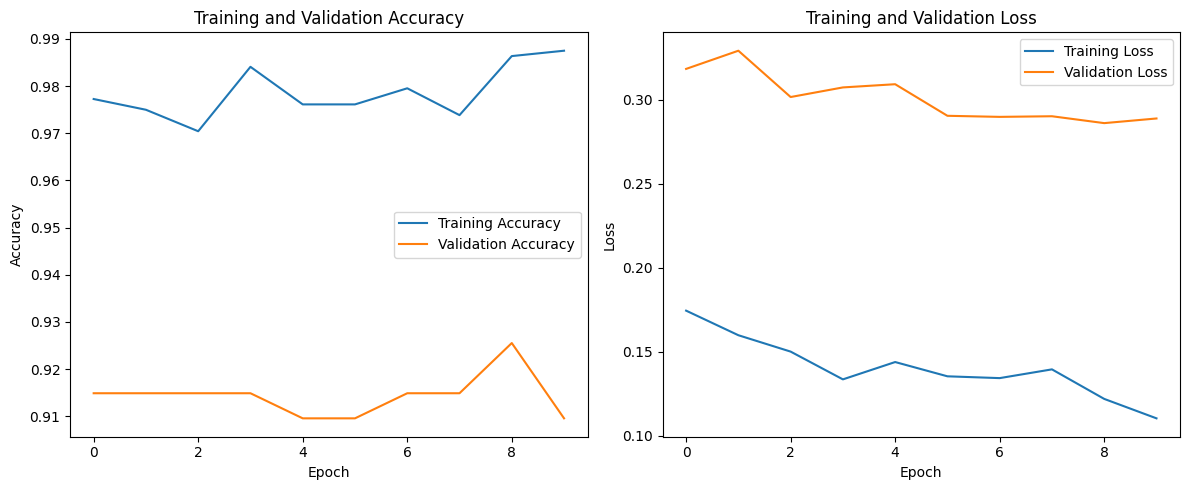

In [18]:
import matplotlib.pyplot as plt

# Create a figure and two subplots
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
import numpy as np

# Get predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from the test generator
true_classes = test_generator.classes

print("Predictions and true labels obtained.")

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 969ms/step
Predictions and true labels obtained.


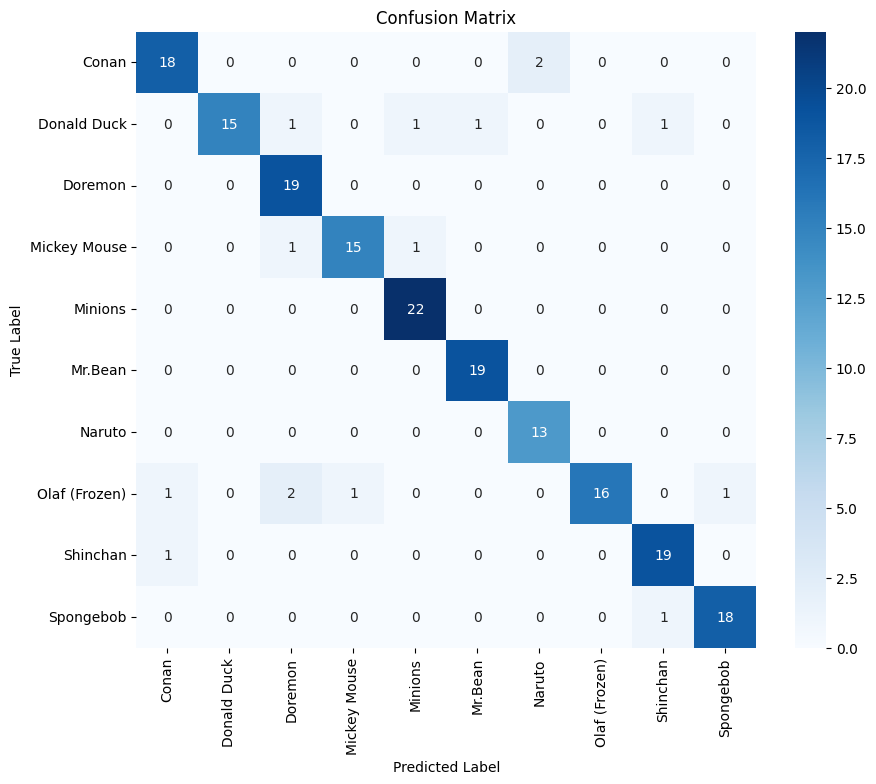

Confusion matrix generated and displayed successfully.


In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Confusion matrix generated and displayed successfully.")

In [28]:
from PIL import Image
import numpy as np
from google.colab import files

print("Please upload an image file.")
uploaded = files.upload()

# Get the filename of the uploaded image
for fn in uploaded.keys():
    uploaded_filename = fn

# Load the image
img = Image.open(uploaded_filename)

# Resize the image to 224x224
img = img.resize((224, 224))

# Convert the image to a NumPy array
img_array = np.array(img)

# Expand dimensions to add a batch dimension
# The model expects input shape (batch_size, height, width, channels)
preprocessed_img = np.expand_dims(img_array, axis=0)

# Normalize pixel values (scale to [0, 1])
preprocessed_img = preprocessed_img / 255.0

print(f"Uploaded image '{uploaded_filename}' preprocessed successfully.")
print(f"Preprocessed image shape: {preprocessed_img.shape}")

Please upload an image file.


Saving 7-77957_baby-mickey-mouse-sleeping-clipart-png-baby-mickey.jpg to 7-77957_baby-mickey-mouse-sleeping-clipart-png-baby-mickey.jpg
Uploaded image '7-77957_baby-mickey-mouse-sleeping-clipart-png-baby-mickey.jpg' preprocessed successfully.
Preprocessed image shape: (1, 224, 224, 3)


**Reasoning**:
The subtask of allowing the user to upload and preprocess a custom image for the model has been successfully completed by the previous code block. I will now predict the class of the uploaded image using the trained model.



In [29]:
predictions = model.predict(preprocessed_img)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get class labels from the test_generator to map the index to the class name
class_indices = test_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

predicted_class_label = idx_to_class[predicted_class_index]

print(f"The uploaded image is predicted to be a: {predicted_class_label}")
print(f"Prediction probabilities: {predictions[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
The uploaded image is predicted to be a: Mickey Mouse
Prediction probabilities: [3.0683572e-04 1.7235130e-02 1.7757341e-02 9.3671763e-01 1.1189817e-02
 2.6312680e-03 2.8049930e-05 2.5148124e-03 1.0069458e-02 1.5496487e-03]


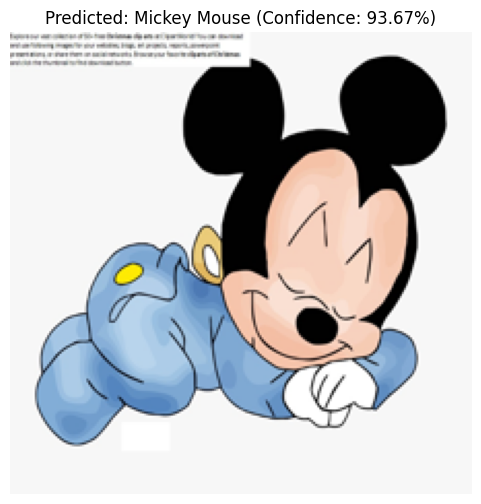

Custom image displayed with prediction and confidence.


In [30]:
import matplotlib.pyplot as plt

# Display the uploaded image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')

# Get the confidence for the predicted class
confidence = predictions[0][predicted_class_index] * 100

# Add title with predicted label and confidence
plt.title(f"Predicted: {predicted_class_label} (Confidence: {confidence:.2f}%)")
plt.show()

print("Custom image displayed with prediction and confidence.")